# Getting started with Aehmc

In [1]:
import time

import arviz as az
import numpy as np
import pymc as pm

import aesara
import aesara.tensor as at
from aesara.tensor.random.utils import RandomStream
from aeppl.transforms import TransformValuesRewrite, LogTransform

from aeppl import joint_logprob

import aehmc.hmc as hmc
import aehmc.nuts as nuts
from aehmc.utils import RaveledParamsMap

In [2]:
NUM_INTEGRATION_STEPS = 1024
STEP_SIZE = 5e-5
PATH_LENGTH = STEP_SIZE * NUM_INTEGRATION_STEPS

NUM_SAMPLES = 1_000
BURNIN = 100

## The model: a simple linear regression

We consider a simple one-dimensional regression problem. To make it a little challenging, we create a dataset with 10,000 points:

In [3]:
rng = np.random.default_rng(0)
X_val = rng.normal(0, 1, size=(10_000,))
y_val = 3 * X_val + rng.normal(0,1)

### PyMC implementation

Let us first implement the model with PyMC

In [4]:
with pm.Model() as pymc_model:
    weights = pm.Normal("weights", mu=0, sigma=1)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    y_observed = pm.Normal(
        "y_observed",
        mu=X_val @ weights,
        sigma=noise,
        observed=y_val,
    )

### Aesara/AePPL implementation

The previous model can be implemented in `Aesara` following:

In [5]:
import aesara.tensor as at

X_at = at.as_tensor(X_val)

srng = at.random.RandomStream(0)
w_rv = srng.normal(0, 1.0)
n_rv = srng.gamma(2.0, 1.0)
Y_rv = srng.normal(X_at.dot(w_rv), n_rv)

To use the HMC and NUTS sampler we need to build a graph that computes the model's joint log-probability distribution. We use `Aeppl`'s to do so. 

`AeHMC`'s samplers operate on flat arrays, we thus need to ravel parameters to pass them to the sampling algorithm,  and unravel them before the joint log-probability graph is constructed:

In [6]:
# `aehmc` kernels take a vector as an input. We use a `RaveledParamsMap` to unravel this vector
# and retrieve ta values for `w_rv` and `Y_rv`.
rp_map = RaveledParamsMap((w_rv, n_rv))


def aeppl_logprob(q):
    unraveled_params = rp_map.unravel_params(q)
    n_vv = unraveled_params[n_rv]
    w_vv = unraveled_params[w_rv]
    
    # The gamma distribution's support is the positive real numbers; algorithms like HMC however prefer to work 
    # with parameters on the real line. We thus apply a log transform to `n_vv`. Batteries-included PPLs like 
    # PyMC3 apply this transform automatically.
    transforms_op = TransformValuesRewrite({n_vv: LogTransform()})

    logprob = joint_logprob({Y_rv: at.as_tensor(y_val), n_rv: n_vv, w_rv: w_vv}, extra_rewrites=transforms_op)
    return logprob

We can check that the loglikelihood returns the same values as the logpdf produced by PyMC3:

In [7]:
q = at.vector('q')
logprob_fn = aesara.function((q,), aeppl_logprob(q))
logprob_aehmc = logprob_fn([3., np.log(10.)])
print(f"Log-probability with AeHMC: {logprob_aehmc}")

#logprob_pymc = pymc_model.joint_logp({'weights':3, 'noise_log__': np.log(10)})
#print(f"Log-probability with PyMC:  {logprob_pymc}")

Log-probability with AeHMC: -32238.026021294307


## Sampling using the HMC algorithm

### Using AeHMC

The `hmc.new_kernel` function returns, given the parameters of the HMC algorithm (a random seed, the potential, the step size, inverse mass matrix and number of integration steps) returns a "kernel" which given a chain state returns a graph that computes the next chain state:

#### How the kernel works

In [8]:
srng = RandomStream(seed=0)
inverse_mass_matrix = at.as_tensor(np.array([1., 1.]))
kernel = hmc.new_kernel(srng, aeppl_logprob)

Let us compile this graph into a function:

In [9]:
q = at.vector("q")
potential_energy = -aeppl_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

next_step, updates = kernel(
    q,
    potential_energy,
    potential_energy_grad,
    STEP_SIZE,
    inverse_mass_matrix,
    NUM_INTEGRATION_STEPS
)
kernel_fn = aesara.function((q,), next_step, updates=updates)

Let's run the kernel for one step:

In [10]:
kernel_fn(np.array([3., np.log(.21)]))

[array([ 2.99946192, -1.30494977]),
 array(12433.00653542),
 array([  -489.93218536, -22571.36970197]),
 array(1.),
 array(False)]

#### Build the trajectory

We can also build a graph that computes the entire trajectory given the initial position and a number of samples, using aesara `scan` construct:

In [11]:
q = at.vector("q")
potential_energy = -aeppl_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

srng = RandomStream(seed=0)
step_size = at.scalar("step_size")
inverse_mass_matrix = at.vector("inverse_mass_matrix")
num_samples = at.scalar("num_samples", dtype="int32")
num_integration_steps = at.scalar("num_integration_steps", dtype="int32")

kernel = hmc.new_kernel(srng, aeppl_logprob)

trajectory, updates = aesara.scan(
    fn=kernel,
    outputs_info=[
        {"initial": q},
        {"initial": potential_energy},
        {"initial": potential_energy_grad},
        None,
        None,
    ],
    non_sequences=(step_size, inverse_mass_matrix, num_integration_steps),
    n_steps=num_samples,
)
trajectory_generator = aesara.function(
    (q, step_size, inverse_mass_matrix, num_integration_steps, num_samples),
    trajectory,
    updates=updates,
    mode='FAST_RUN'
)

We can now compile the function that generates the chain and execute it:

In [12]:
%%time
initial_position = np.array([3., np.log(0.5)])
inverse_mass_matrix = np.array([1., 1.])
position, *_ = trajectory_generator(initial_position, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS, NUM_SAMPLES)

CPU times: user 1min 6s, sys: 86.2 ms, total: 1min 6s
Wall time: 1min 6s


Let us quickly check that the chain sampled correctly:

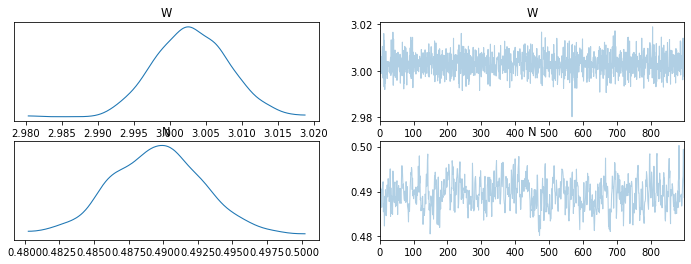

In [13]:
aehmc_trace_aehmc_hmc = az.from_dict(posterior={"W": position[BURNIN:, 0], "N": np.exp(position[BURNIN:, 1])})
az.plot_trace(aehmc_trace_aehmc_hmc);

### Using PyMC

Let us now compare the performance of AeHMC's HMC algorithm with that of PyMC's.

In [14]:
with pymc_model:
    step = pm.step_methods.hmc.hmc.HamiltonianMC(
        [weights, noise],
        path_length=PATH_LENGTH,
        step_scale=STEP_SIZE,
        adapt_step_size=False,
    )
    
    # Set initial values
    weights.tag.test_value = initial_position[0]
    noise.tag.test_value = initial_position[1]
    
with pymc_model:
    start = time.perf_counter()
    posterior = pm.sample(
        tune=0,
        draws=NUM_SAMPLES,
        step=[step],
        chains=1,
        cores=1,
        return_inferencedata=False,
        compute_convergence_checks=False
    )
    end = time.perf_counter()
    print(f"PyMC took {end - start:.2f}s to sample")

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [weights, noise]


Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 96 seconds.
The acceptance probability does not match the target. It is 1, but should be close to 0.65. Try to increase the number of tuning steps.


PyMC took 95.76s to sample


## Using the NUTS algorithm

The NUTS algorithm is a variant of the HMC algorithm where the number of integration steps is set dynamically.

### With AeHMC

In [15]:
q = at.vector("q")
potential_energy = -aeppl_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

step_size = at.scalar("step_size")
inverse_mass_matrix = at.vector("inverse_mass_matrix")

srng = RandomStream(seed=0)
kernel = nuts.new_kernel(srng, aeppl_logprob)

num_samples = at.scalar('num_samples', dtype='int32')
trajectory, updates = aesara.scan(
    fn=kernel,
    outputs_info=[
        {"initial": q},
        {"initial": potential_energy},
        {"initial": potential_energy_grad},
        None,
        None,
        None,
        None,
    ],
    non_sequences=(step_size, inverse_mass_matrix),
    n_steps=num_samples,
)
trajectory_generator = aesara.function(
    (q, step_size, inverse_mass_matrix, num_samples),
    trajectory,
    updates=updates,
)

In [16]:
%%time

# The following values for the parameters were obtained by running PyMC3's warmup
inverse_mass_matrix = np.array([2.13e-05, 4.43e-05])
step_size = 0.8

initial_position = np.array([3., np.log(0.49)])
position, *_ = trajectory_generator(initial_position, step_size, inverse_mass_matrix, NUM_SAMPLES)

CPU times: user 4.44 s, sys: 26.2 ms, total: 4.47 s
Wall time: 4.47 s


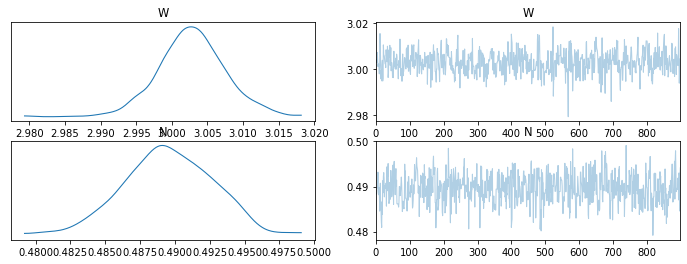

In [17]:
aehmc_trace = az.from_dict(posterior={"W": position[BURNIN:, 0], "N": np.exp(position[BURNIN:, 1])})
az.plot_trace(aehmc_trace);

### With PyMC3

We are now ready to compare the performance of `aehmc`'s HMC kernel to that of PyMC3.

In [18]:
with pymc_model:
    step = pm.step_methods.hmc.NUTS(
        [weights, noise],
    )
    
with pymc_model:
    start = time.perf_counter()
    posterior = pm.sample(
        tune=2000,
        draws=NUM_SAMPLES,
        step=[step],
        chains=1,
        cores=1,
        return_inferencedata=False,
        compute_convergence_checks=False
    )
    end = time.perf_counter()
    print(f"Sampling with PyMC3 took {end - start:.2f}s")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [weights, noise]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 2 seconds.


Sampling with PyMC3 took 2.05s
